# 4. Internal Linear Combination (ILC) applied to wavelet coefficient maps across all frequency channels at each scale with multiprocessing

In [1]:
import math
# import pys2let as ps
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
from s2wav import filters
import healpy as hp
import numpy as np
import s2wav
import skyclean
import time
import math
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline 

/home/matthew/ENTER/envs/skyclean‐fix/lib/python3.13/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.2 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


### 4.1 Create the directory structure to store data

In [2]:
def check_and_create_ilc_directories():
    """
    Checks for the existence of a specific nested directory structure for ILC processing and creates any missing directories.
    This includes handling multiple levels of nested directories as shown in the provided folder structure.

    The structure checked is:
    - ILC
      - covariance_matrix
      - ILC_doubled_maps
      - ILC_processed_wavelet_maps
      - synthesized_ILC_MW_maps
      - wavelet_doubled
      - weight_vector_data
    """

    # Define the root directories
    # base_dir = "path_to_base_directory"  # Set this to your base directory path
    # ilc_dir = os.path.join(base_dir, "ILC")
    ilc_dir = "data/ILC"
    # List of directories under the ILC directory
    ilc_sub_dirs = ["covariance_matrix", "ILC_doubled_maps", "ILC_processed_wavelet_maps", "synthesized_ILC_MW_maps","wavelet_doubled","weight_vector_data",
                   "scal_coeffs"]

    # Create the ILC directory and its subdirectories
    create_directory(ilc_dir)
    for sub_dir in ilc_sub_dirs:
        create_directory(os.path.join(ilc_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed
check_and_create_ilc_directories()


Created directory: data/ILC
Created directory: data/ILC/covariance_matrix
Created directory: data/ILC/ILC_doubled_maps
Created directory: data/ILC/ILC_processed_wavelet_maps
Created directory: data/ILC/synthesized_ILC_MW_maps
Created directory: data/ILC/wavelet_doubled
Created directory: data/ILC/weight_vector_data
Created directory: data/ILC/scal_coeffs


### 4.2 ILC functions 

multiprocessing: 

(all scales, all frequencies)

double_and_save_wavelet_maps_MP: Double the resolution of the wavelet coefficient maps and save them.

calculate_covariance_matrix_MP: Calculates the covariance matrices for all given frequencies and saves them to 1 4d array (9,9,pixel dimension 1, pixel dimension 2).

(all scales)

trim_to_original: 
Trims the ILC doubled wavelet coefficient map to its original resolution.


In [3]:

def mw_alm_2_hp_alm(MW_alm, lmax):
    """
    Converts MW alm coefficients to HEALPix alm coefficients.

    Args:
        MW_alm (ndarray): 2D array of shape (Lmax, 2*Lmax-1) representing MW alm coefficients.
        lmax (int): Maximum multipole moment.

    Returns:
        ndarray: 1D array of HEALPix alm coefficients.
    """
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

def Single_Map_doubleworker(MW_Pix_Map):
    """
    Doubles the resolution of a single wavelet map.

    Args:
        MW_Pix_Map (ndarray): Wavelet pixel map to be doubled in resolution.

    Returns:
        ndarray: Doubled resolution wavelet map.
    """
    MW_alm = s2fft.forward(MW_Pix_Map, L=MW_Pix_Map.shape[1])
    L = MW_alm.shape[0]
    padded_alm = np.zeros((2*L-1, 2*(2*L-1)-1), dtype=np.complex128)
    
    inner_matrix_middle = MW_alm.shape[1] // 2
    outer_matrix_middle = padded_alm.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + MW_alm.shape[1]
      
    padded_alm[:MW_alm.shape[0], start_col:end_col] = MW_alm
    MW_Pix_Map_doubled = np.real(s2fft.inverse(padded_alm, L=padded_alm.shape[0]))
    
    return MW_Pix_Map_doubled

def load_frequency_data(file_template, frequencies, scales, realization):
    """
    Loads wavelet data from files for different frequencies and scales.

    Args:
        base_path (str): Base directory containing the wavelet files.
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): Realization identifier as a string.

    Returns:
        dict: Dictionary where keys are tuples (frequency, scale) and values are loaded wavelet data arrays.
    """
    
    frequency_data = {}
    realization = str(realization).zfill(4)
    for frequency in frequencies:
        for scale in scales:
            path = f"{file_template.format(frequency=frequency, scale=scale, realization=realization)}"
            # print(path)
            try:
                frequency_data[(frequency, scale)] = np.load(path)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}, realization {realization}")
    return frequency_data

def save_doubled_wavelet_map(args):
    """
    Helper function to save a doubled wavelet map.

    Args:
        args (tuple): Contains the wavelet map data, frequency, scale, realization, and path template.
    """
    original_map, frequency, scale, realization, path_template = args
    doubled_map = Single_Map_doubleworker(original_map)
    save_path = path_template.format(frequency=frequency, scale=scale, realization=realization)
    np.save(save_path, doubled_map)

def double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization, path_template):
    """
    Doubles the resolution of the wavelet coefficient maps using multiprocessing.

    Args:
        original_wavelet_c_j (dict): Dictionary containing the original wavelet maps.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): The realization number for file naming.
        path_template (str): Template for saving the doubled wavelet maps.
    """
    tasks = [(original_wavelet_c_j[(i, j)], i, j, realization, path_template) for i in frequencies for j in scales]
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(save_doubled_wavelet_map, tasks)

def smoothed_covariance(MW_Map1, MW_Map2):
    """
    Computes covariance between two wavelet maps with smoothing.

    Args:
        MW_Map1 (ndarray): First wavelet coefficient map.
        MW_Map2 (ndarray): Second wavelet coefficient map.

    Returns:
        ndarray: Smoothed covariance map.
    """
    smoothing_lmax = MW_Map1.shape[0]
    map1 = np.real(MW_Map1)
    map2 = np.real(MW_Map2)
    R_MW_Pixel_map = np.multiply(map1, map2) + 0.j

    R_MW_alm = s2fft.forward(R_MW_Pixel_map, L=smoothing_lmax)
    nsamp = 1200.0
    lmax_at_scale_j = R_MW_alm.shape[0]
    npix = hp.nside2npix(1 << (int(0.5*lmax_at_scale_j)-1).bit_length())
    scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
    gauss_smooth = hp.gauss_beam(scale_fwhm, lmax=smoothing_lmax-1)
    MW_alm_beam_convolved = np.zeros(R_MW_alm.shape, dtype=np.complex128)

    MW_alm_beam_convolved = R_MW_alm * gauss_smooth[:, None]
    # for i in range(R_MW_alm.shape[1]):
    #     MW_alm_beam_convolved[:, i] = R_MW_alm[:, i] * gauss_smooth
    
    R_covariance_map = np.real(s2fft.inverse(MW_alm_beam_convolved, L=smoothing_lmax))
    return R_covariance_map


def compute_covariance(task):
    """
    Computes the covariance between two frequency maps at a given scale.
    
    Args:
    task (tuple): A tuple containing (i, fq, frequencies, scale, doubled_MW_wav_c_j).
    
    Returns:
    tuple: A tuple containing indices i, fq and the computed covariance matrix.
    """
    i, fq, frequencies, scale, doubled_MW_wav_c_j = task
    key_i = (frequencies[i], scale)
    key_fq = (frequencies[fq], scale)
    if key_i not in doubled_MW_wav_c_j or key_fq not in doubled_MW_wav_c_j:
        raise KeyError(f"Missing data for keys {key_i} or {key_fq}.")
    return i, fq, smoothed_covariance(doubled_MW_wav_c_j[key_i], doubled_MW_wav_c_j[key_fq])

def calculate_covariance_matrix_MP(frequencies, doubled_MW_wav_c_j, scale, realization, path_template):
    """
    Calculates the covariance matrices for all given frequencies and saves them to disk using a provided template,
    accommodating any size of the input data arrays using multiprocessing.

    Args:
        frequencies (list): List of frequency indices.
        doubled_MW_wav_c_j (dict): Dictionary containing data arrays for covariance calculations.
        scale (int): The scale.
        realization (str): The realization identifier.
        path_template (str): Template string for saving the covariance matrices, with placeholders for combined frequencies, scale, and realization.
        
    Returns:
        full_array: np.ndarray: A 4D array containing the covariance matrices for the given frequencies.
    """
    if frequencies:
        sample_data = doubled_MW_wav_c_j.get((frequencies[0], scale))
        if sample_data is None:
            raise KeyError(f"Data for frequency '{frequencies[0]}' and scale '{scale}' is missing.")
        n_rows, n_cols = sample_data.shape
    else:
        raise ValueError("Frequency list is empty.")
    
    total_frequency = len(frequencies)
    full_array = np.zeros((total_frequency, total_frequency, n_rows, n_cols))
    
    # Calculate the covariance matrix and save each one
    # Calculate the upper triangle only since the matrix is symmetric
    tasks = [(i, fq, frequencies, scale, doubled_MW_wav_c_j) for i in range(total_frequency) for fq in range(i, total_frequency)]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(compute_covariance, tasks)
        for result in results:
            i, fq, covariance_matrix = result
            full_array[i, fq] = covariance_matrix
    
    # Testing if the multiprocessing output is the same as the single process output 
    # np.save(f"ILC/covariance_matrix/half_cov_1_{scale}", full_array)
    
    # Fill the symmetric part of the matrix
    for l1 in range(1, total_frequency):
        for l2 in range(l1):
            full_array[l1, l2] = full_array[l2, l1]

    f_str = '_'.join(frequencies)
    save_path = path_template.format(frequencies=f_str, scale=scale, realization=realization)
    np.save(save_path, full_array)

    return full_array

def compute_weight_vector(R, scale, realization, weight_vector_matrix_template):
    """
    Processes the given 4D matrix R by computing and saving the weight vectors for each matrix in the first two dimensions.
    
    Args:
        R (np.ndarray): The input covariance matrix, either 2D or 4D.
        scale (int): The scale index.
        realization (str): The realization identifier.
        weight_vector_matrix_template (str): Template for saving the weight vector matrices.

    Returns:
        Returns:
        inverses: (np.ndarray): An Array containing the inverse matrices
        weight_vectors (np.ndarray): A 3D Array containing the weight vector.
        The size of the first two dimensions of the weight vector is the size of the wavelet coefficient map at the given scale.
        The third dimension is the weight vector (The contribution from each frequency).
        Each element of the weight vector is a 1D array.
        singular_matrices_location (list): The locations of singular matrices.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    identity_vector = np.ones(subdim2, dtype=float)
    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                if R.ndim == 4:
                    inverse_matrix = np.linalg.inv(R_Pix[i, j])
                    inverses[i, j] = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors[i, j] = numerator / denominator
                else:
                    inverse_matrix = np.linalg.inv(R_Pix)
                    inverses = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors = numerator / denominator
            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j
                )
                np.save(singular_matrix_path, R_Pix[i, j] if R.ndim == 4 else R_Pix)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(len(identity_vector))
                else:
                    weight_vectors = np.zeros(len(identity_vector))

    np.save(weight_vector_matrix_template.format(type="weight_vector", scale=scale, realization=realization), weight_vectors)
    return inverses, weight_vectors, singular_matrices_location

def process_matrix_worker(args):
    """
    Worker function for processing a single matrix in parallel.

    Args:
        args (tuple): Arguments including the matrix to process, indices, and paths for saving.
    """
    R_Pix_ij, i, j, scale, realization, identity_vector, inverses, weight_vectors, singular_matrices_location, path_template = args
    
    try:
        inverses[i, j] = np.linalg.inv(R_Pix_ij)
        numerator = np.dot(inverses[i, j], identity_vector)
        denominator = np.dot(numerator, identity_vector)
        weight_vectors[i, j] = numerator / denominator
    except np.linalg.LinAlgError:
        singular_matrices_location.append((i, j))
        np.save(path_template.format(type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j), R_Pix_ij)
        weight_vectors[i, j] = np.zeros(len(identity_vector))




def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[scale][i, j], pix_vector)

def create_doubled_ILC_map(frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization):
    size = doubled_MW_wav_c_j[(frequencies[0],scale)].shape
    doubled_map = np.zeros((size[0], size[1]))
    
    for i in range(doubled_map.shape[0]):
        for j in range(doubled_map.shape[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(i, j, frequencies, scale,weight_vector_load, doubled_MW_wav_c_j)
    np.save(f"data/ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP", doubled_map)
    return doubled_map

def trim_to_original(MW_Doubled_Map, scale, realization, path_template):
    """
    Trims the doubled map to its original resolution.

    Args:
        MW_Doubled_Map (ndarray): Doubled wavelet map to be trimmed.
        scale (int): Scale index.
        realization (str): The realization number for file naming.
        path_template (str): Template for saving the trimmed maps.

    Returns:
        ndarray: Trimmed wavelet map.
    """
    MW_alm_doubled = s2fft.forward(MW_Doubled_Map, L=MW_Doubled_Map.shape[0])
    inner_matrix_vertical = (MW_Doubled_Map.shape[0] + 1) // 2
    inner_matrix_horizontal = 2 * inner_matrix_vertical - 1
    
    inner_matrix_middle = inner_matrix_horizontal // 2
    outer_matrix_middle = MW_Doubled_Map.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + inner_matrix_horizontal

    trimmed_alm = MW_alm_doubled[:inner_matrix_vertical, start_col:end_col]
    MW_Pix_Map_original = s2fft.inverse(trimmed_alm, L=trimmed_alm.shape[0])[np.newaxis, ...]
    np.save(path_template.format(scale=scale, realization=realization), MW_Pix_Map_original)
    return MW_Pix_Map_original

def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if not is_MW_alm:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("MW alm shape:", original_map_alm.shape)
    else:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()



def synthesize_ILC_maps(trimmed_maps, realization, output_templates, L_max, N_directions):
    """
    Synthesizes ILC maps from trimmed wavelet maps, visualizes the results, and saves the synthesized maps.

    Args:
        trimmed_maps (list of np.ndarray): List of trimmed wavelet maps for different scales.
        realization (str): The realization identifier.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of directions for the directional wavelet filters.

    Returns:
        np.ndarray: The synthesized ILC map.
    """
    
    # Load the scaling coefficients using the template path
    f_scal = np.load(output_templates['f_scal'].format(realization=realization))

    # Create the directional filters
    filter = filters.filters_directional_vectorised(L_max, N_directions)

    # Perform the synthesis to obtain the ILC map
    MW_Pix = s2wav.synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter, N=N_directions)

    # Visualize the synthesized ILC map
    title = f"ILC CMB Map realization: {realization}"
    visualize_MW_Pix_map(MW_Pix, title)

    # Save the synthesized ILC map
    np.save(output_templates['synthesized_maps'].format(realization=realization), MW_Pix)
    
    return MW_Pix



def ILC_wav_coeff_maps_MP(file_template, frequencies, scales, realizations, output_templates, L_max, N_directions):
    
    """
    Processes wavelet maps for a range of realizations, including doubling, covariance calculation,
    matrix processing, and trimming to original resolution, using multiprocessing for efficiency
    where tasks are independent.

    Args:
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realizations (list): List of realizations to process.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        
    Returns:
        list: List of trimmed maps for the final processed realization.
    """

    synthesized_maps = []

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")
        path = output_templates['trimmed_maps'].format(scale=scales[0], realization=realization_str)
        
        # Timing for loading the original wavelet maps
        # start_time = time.perf_counter()
        original_wavelet_c_j = load_frequency_data(file_template, frequencies, scales, realization_str)
        # load_time = time.perf_counter() - start_time
        # print(f'Loaded original wavelet maps in {load_time:.2f} seconds')

        # Timing for doubling and saving wavelet maps
        start_time = time.perf_counter()
        double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization_str, output_templates['doubled_maps'])
        double_time = time.perf_counter() - start_time
        print(f'Doubled and saved wavelet maps in {double_time:.2f} seconds')

        # loading doubled wavelet maps
        doubled_MW_wav_c_j = load_frequency_data(output_templates['doubled_maps'], frequencies, scales, realization_str)
       

        # Timing for calculating covariance matrices with multiprocessing
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            covariance_tasks = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale, realization_str, output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(covariance_tasks):
                future.result()  # Wait for all tasks to complete
        covariance_time = time.perf_counter() - start_time
        print(f'Calculated covariance matrices in {covariance_time:.2f} seconds')

        # Timing for processing and saving matrices with multiprocessing
        start_time = time.perf_counter()
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(
                frequencies=F_str, scale=i, realization=realization_str))
            for i in range(len(scales))
        ]
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            process_tasks = [
                executor.submit(
                    compute_weight_vector,
                    R_covariance[scale_idx], scale, realization_str, output_templates['weight_vector_matrices']
                )
                for scale_idx, scale in enumerate(scales)
            ]
            for future in concurrent.futures.as_completed(process_tasks):
                future.result()  # Wait for all tasks to complete
        process_time = time.perf_counter() - start_time
        print(f'Calculate weight vector matrices in {process_time:.2f} seconds')

        # Timing for creating ILC maps with multiprocessing
        start_time = time.perf_counter()
        weight_vector_load = [
            np.load(output_templates['weight_vector_matrices'].format(
                type="weight_vector", scale=i, realization=realization_str))
            for i in range(len(scales))
        ]

        ####################
        # Unused code for creating doubled ILC map: multiprocessing is slow 
        # with concurrent.futures.ProcessPoolExecutor() as executor:
        #     # Submit tasks for each scale to be processed in parallel
        #     futures = [
        #         executor.submit(
        #             create_doubled_ILC_map,
        #             frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization_str, output_templates['ilc_maps']
        #         )
        #         for scale in scales
        #     ]
            
        #     # Collect the results as they complete
        #     doubled_maps = [future.result() for future in concurrent.futures.as_completed(futures)]
    
        #####################
        
        doubled_maps = []
        for i in range(len(scales)):
            doubled_maps.append(create_doubled_ILC_map(frequencies, scales[i], weight_vector_load, doubled_MW_wav_c_j, realization=realization_str))

        doubled_maps = [np.load(f"data/ILC/ILC_doubled_maps/ILC_Map_S{i}_R{realization_str}_MP.npy") for i in range(len(scales))]

        ilc_time = time.perf_counter() - start_time
        print(f'Created ILC maps in {ilc_time:.2f} seconds')

        # Load the ILC maps
        doubled_maps = [np.load(output_templates['ilc_maps'].format(scale=i, realization=realization_str)) for i in range(len(scales))]

        # Timing for trimming to original resolution with multiprocessing
        start_time = time.perf_counter()

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(trim_to_original, doubled_maps[scale], scale, realization_str, output_templates['trimmed_maps'])
                for scale in scales
            ]
            trimmed_maps = [future.result() for future in concurrent.futures.as_completed(futures)]

        trim_time = time.perf_counter() - start_time
        print(f'Trimmed maps to original resolution in {trim_time:.2f} seconds')

        # Timing for visualizing wavelet coefficient maps
        start_time = time.perf_counter()
        for scale in scales:
            title = "ILC Wavelet coefficient map at scale: "
            visualize_MW_Pix_map(trimmed_maps[scale], title + str(scale))
        visualize_time = time.perf_counter() - start_time
        print(f'Visualized wavelet coefficient maps in {visualize_time:.2f} seconds')
        

        # Synthesize the ILC map from the trimmed maps
        synthesized_map = synthesize_ILC_maps(trimmed_maps, realization_str, output_templates, L_max, N_directions)
        synthesized_maps.append(synthesized_map)
        

    return synthesized_maps

In [ ]:
# Example usage
# base_path = "wavelet_transform/wavelets/wav_MW_maps"
file_template = "data/wavelet_transform/CSN/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{scale}_R{realization}.npy"
#frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
frequencies = ["030", "100", "353"]
scales = np.arange(0,5+1)
# scales = [3]

realizations = range(1)

output_templates = {
    'doubled_maps': "data/ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "data/ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "data/ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "data/ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "data/ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "data/ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "data/ILC/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

L_max = 1024
N_directions = 1
l = ILC_wav_coeff_maps_MP(file_template, frequencies, scales, realizations, output_templates, L_max, N_directions)


# Processing realization 0000
# Doubled and saved wavelet maps in 32.15 seconds
# Calculated covariance matrices in 545.99 seconds
# Processed and saved matrices in 26.17 seconds
# Created ILC maps in 4.72 seconds
# Trimmed maps to original resolution in 47.44 seconds


# lam:4, Lmax = 1024: over 600 secs and hasnt doubled and saved.


# Lmax: 512, lam = 2
# Processing realization 0000 
# Doubled and saved wavelet maps in 129.75 seconds
# Calculated covariance matrices in 728.55 seconds
# Calculate weight vector matrices in 24.48 seconds
# Created ILC maps in 11.55 seconds
# Trimmed maps to original resolution in 212.31 seconds

# Lmax: 1024, lam =2 
# Processing realization 0000
# Doubled and saved wavelet maps in 1036.05 seconds
# Calculated covariance matrices in 3878.81 seconds
# Calculate weight vector matrices in 83.54 seconds
# Created ILC maps in 26.43 seconds

# Lmax: 1024, lam =4

Processing realization 0000
Doubled and saved wavelet maps in 1227.18 seconds


### 4.4 Visualize ILC combined Wavelet coefficient maps for each scale

MW alm shape: (4, 7)


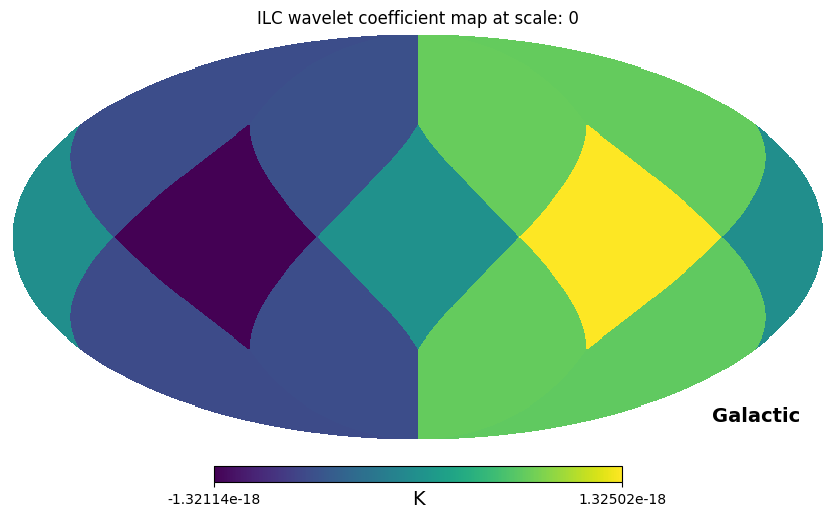

MW alm shape: (4, 7)


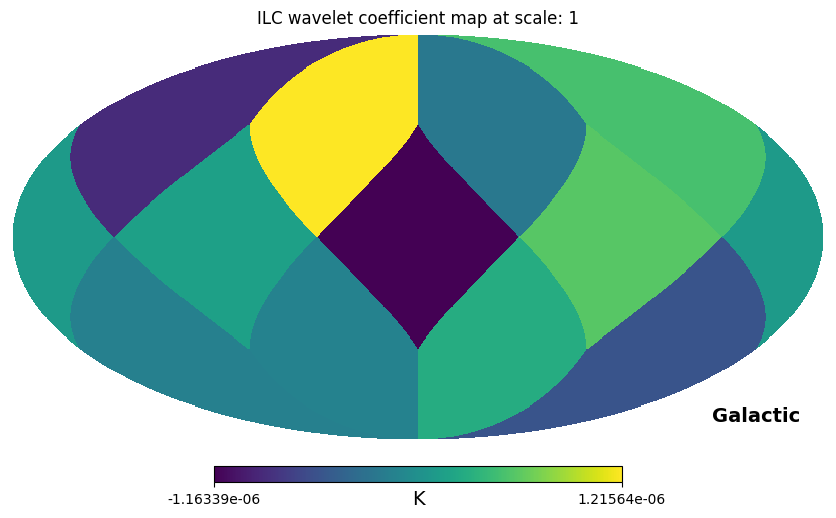

MW alm shape: (8, 15)


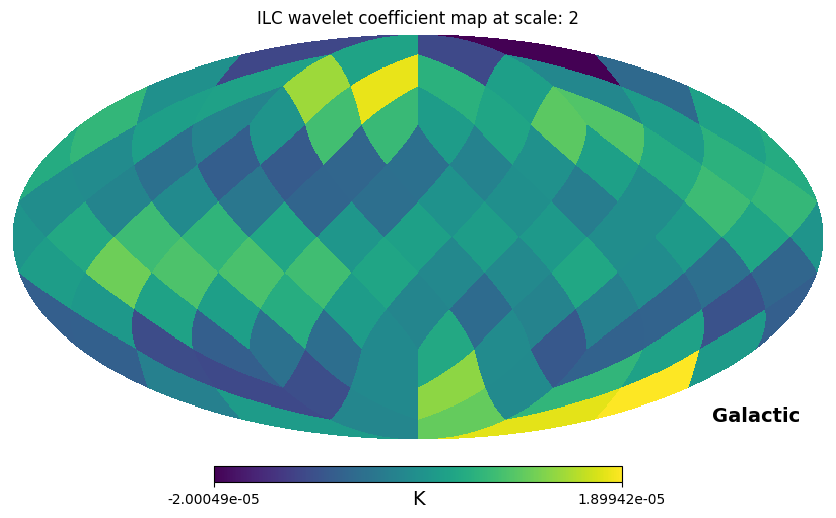

MW alm shape: (16, 31)


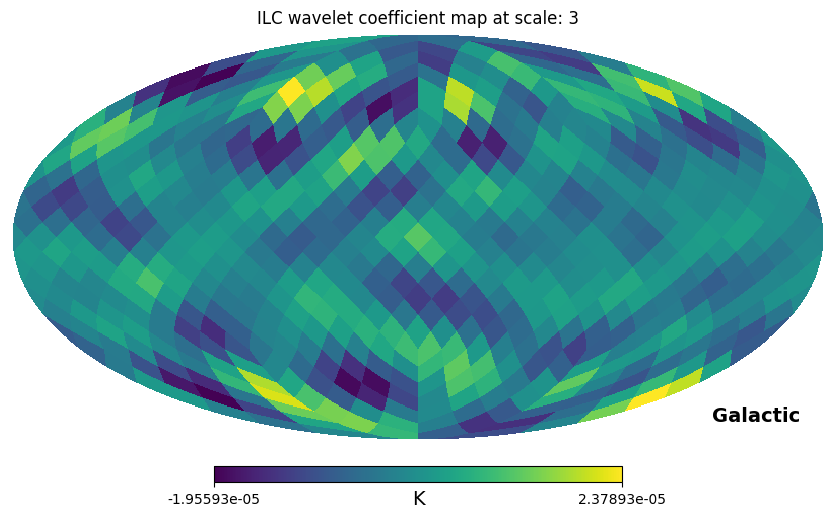

MW alm shape: (32, 63)


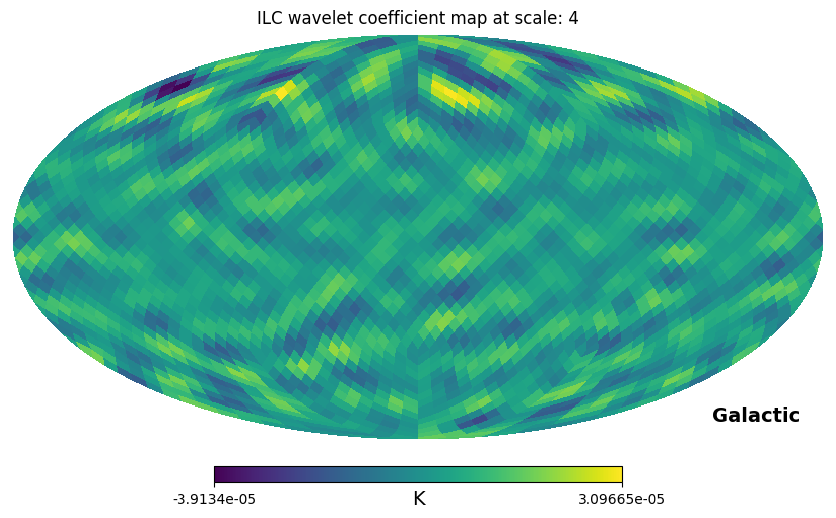

MW alm shape: (64, 127)


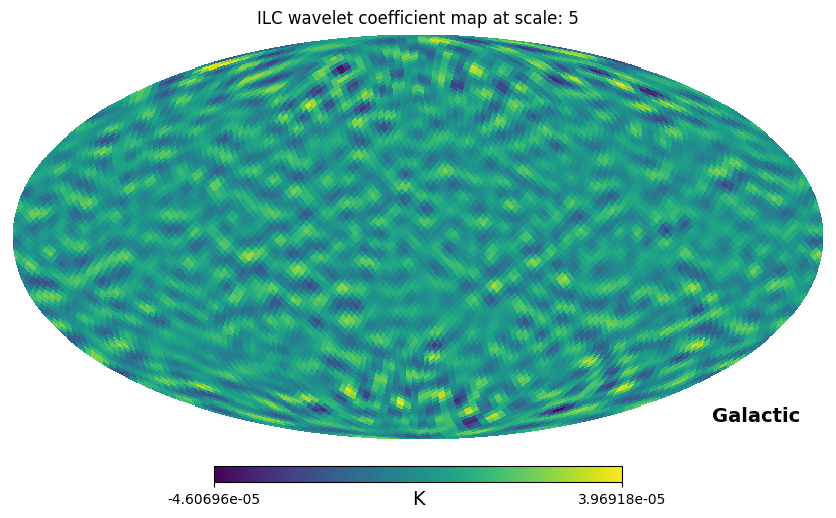

MW alm shape: (128, 255)


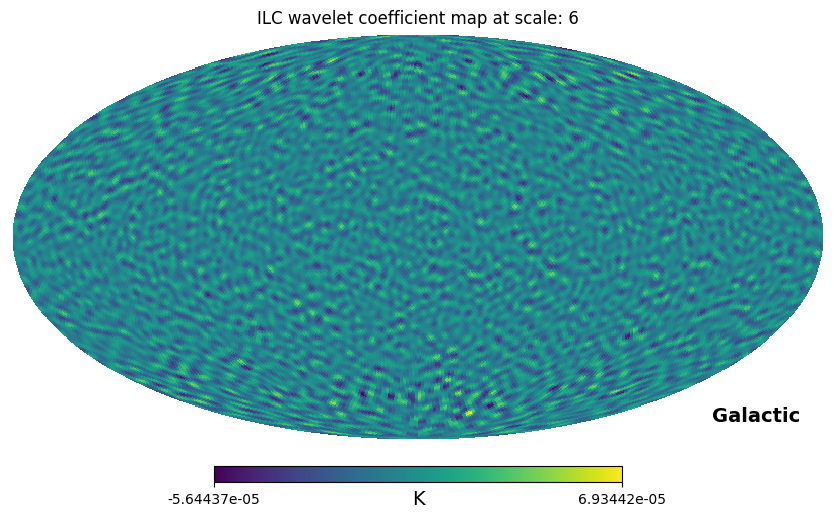

MW alm shape: (256, 511)


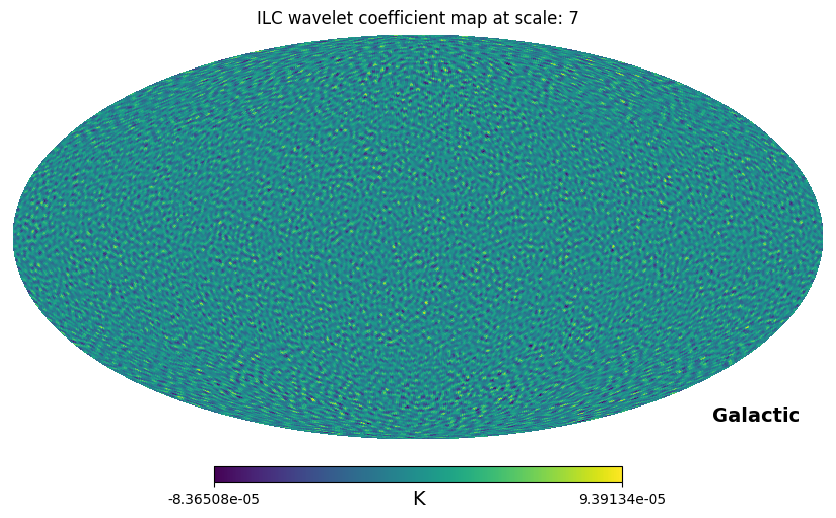

MW alm shape: (256, 511)


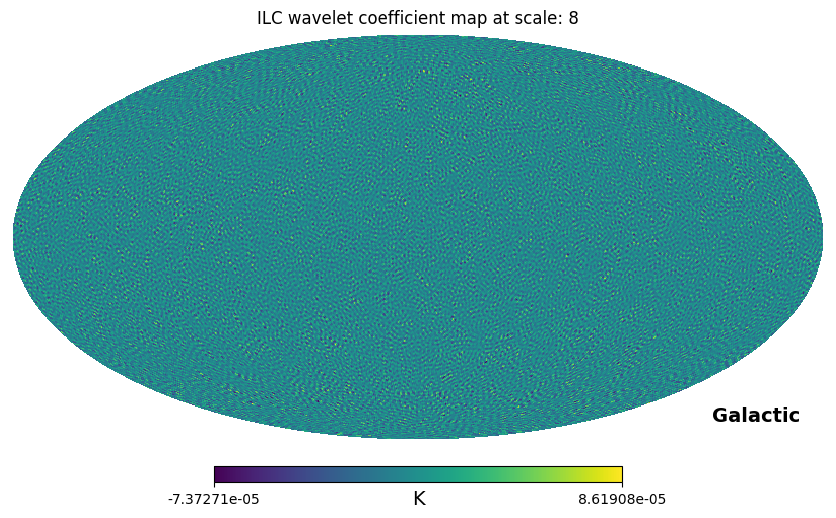

In [7]:

L_max = 1600
N_directions = 1
for r in range(1):
    realization = str(realizations[r]).zfill(4)
    trimmed_maps = [np.load(f"data/ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy") for scale in range(len(scales))]
    for j in range(len(scales)):
        visualize_MW_Pix_map(trimmed_maps[j], "ILC wavelet coefficient map at scale: " + str(j))

### 4.5 Synthesize ILC wavelet coefficient maps of all scales together. (included in ILC_wav_coeff_maps_MP)

The output below is the synthesised ILC estimation of CMB signal for realization 0, and it could be used as a check point for ILC.

Note: Unfinished task for handling scaling coefficient.

MW alm shape: (256, 511)


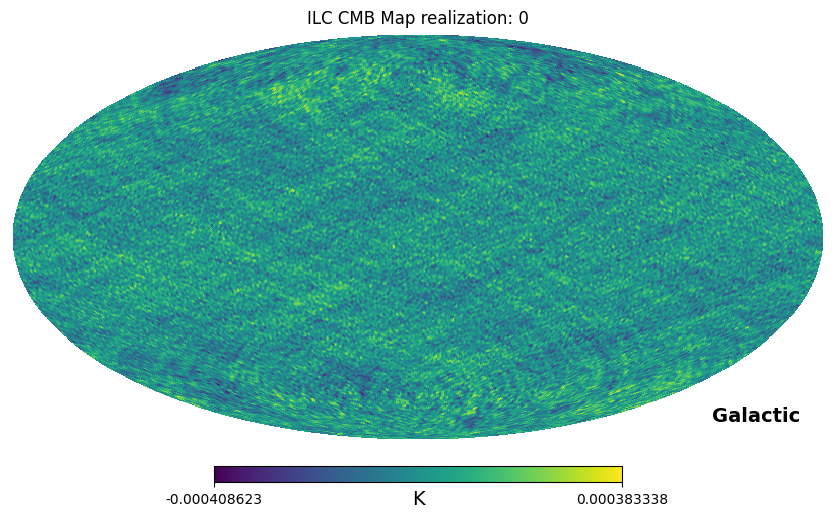

In [15]:
from s2wav import filters
import numpy as np
import s2wav
import s2fft
L_max = 256
N_directions = 1
scales = [0, 1, 2, 3, 4, 5, 6, 7, 8]
realizations = [0]
for i in range(len(realizations)):
    realization = str(realizations[i]).zfill(4)
    trimmed_maps = [np.load(f"data/ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy") for scale in range(len(scales))]

    filter = filters.filters_directional_vectorised(L_max, N_directions)
    # f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
    f_scal = np.load(f"data/wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy") 

    # [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

    MW_Pix = s2wav.synthesis(trimmed_maps, L = L_max, f_scal = f_scal, filters = filter, N = 1)
    title = "ILC CMB Map realization: "
    visualize_MW_Pix_map(MW_Pix, title + str(realizations[i]))
    np.save(f"data/ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}", MW_Pix)

In [ ]:
# from s2wav import filters
# L_max = 32
# N_directions = 1
# for i in range(len(realizations)):
#     realization = str(realizations[i]).zfill(4)
#     trimmed_maps = [np.load(f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{i}_R{realization}.npy") for i in range(len(scales))]

#     filter = filters.filters_directional_vectorised(L_max, N_directions)
#     # f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
#     f_scal = np.array([[0]])    
#     # [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

#     MW_Pix = s2wav.synthesis(trimmed_maps, L = L_max, f_scal = f_scal, filters = filter, N = 1)
#     title = "ILC CMB Map realization: "
#     visualize_MW_Pix_map(MW_Pix, title, str(realizations[i]))
#     np.save(f"ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_0", MW_Pix)